In [85]:
import numpy as np
import librosa
from pathlib import Path
import random

directory = Path("Chords")

max_frames = 40  # fix length for all samples

features = []
labels = []

def augment_audio(y, sr):
    """Apply random audio augmentation to waveform y."""
    
    augmentations = ['gaussian', 'background', 'time', None]
    choice = random.choice(augmentations)
    
    if choice == 'gaussian':
        noise_factor = random.uniform(0.002, 0.02)
        noise = np.random.randn(len(y))
        y = y + noise_factor * noise
        y = np.clip(y, -1.0, 1.0)
    
    elif choice == 'background':
        snr_db = random.uniform(1, 10)  # Signal-to-noise ratio in dB
        noise = np.random.randn(len(y))
        rms_signal = np.sqrt(np.mean(y**2))
        rms_noise = np.sqrt(np.mean(noise**2))
        desired_rms_noise = rms_signal / (10**(snr_db/20))
        noise = noise * (desired_rms_noise / (rms_noise + 1e-6))
        y = np.clip(y + noise, -1.0, 1.0)
    
    elif choice == 'time':
        rate = random.uniform(0.93, 1.06)
        y = librosa.effects.time_stretch(y=y, rate=rate)
    
    return y

for file in directory.rglob("*"):
    if file.is_file():
        filename = file.stem
        chord_name = filename.split('_')[0]  # adjust as needed

        for i in range(30):
            y, sr = librosa.load(str(file))
            y = augment_audio(y, sr)  # apply augmentation

            # Chroma CQT feature
            chroma = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=36)
            chroma = chroma / (np.sum(chroma, axis=0, keepdims=True) + 1e-6)

            # Pad or truncate chroma to fixed length
            if chroma.shape[1] < max_frames:
                pad_width = max_frames - chroma.shape[1]
                chroma = np.pad(chroma, ((0, 0), (0, pad_width)), mode='constant')
            else:
                chroma = chroma[:, :max_frames]

            features.append(chroma)
            labels.append(chord_name)
    
X_mel = np.array(features)  # shape: (num_samples, 40, max_frames)

# Convert to numpy arrays
X = np.array(features)   # shape: (samples, 12, max_frames)
y = np.array(labels)

import numpy as np

X_mean = np.mean(X, axis=2)  # mean chroma per pitch class → shape (samples, 12)
X_std = np.std(X, axis=2)    # std chroma per pitch class → shape (samples, 12)

# Concatenate mean and std features
X_summary = np.concatenate([X_mean, X_std], axis=1)  # shape (samples, 24)


c:\Users\TheAiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=697
  warnings.warn(
c:\Users\TheAiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=689
  warnings.warn(
c:\Users\TheAiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=681
  warnings.warn(
c:\Users\TheAiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=341
  warnings.warn(
c:\Users\TheAiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=661
  warnings.warn(
c:\Users\TheAiro\AppData\Local\Programs\Python\Pyt

0.6653935185185185
0.7459490740740741


,Label,Class
13,A,0
14,A#,1
53,A#m,2
64,Am,3
9,B,4
17,Bm,5
6,C,6
16,C#,7
11,C#m,8
41,Cm,9


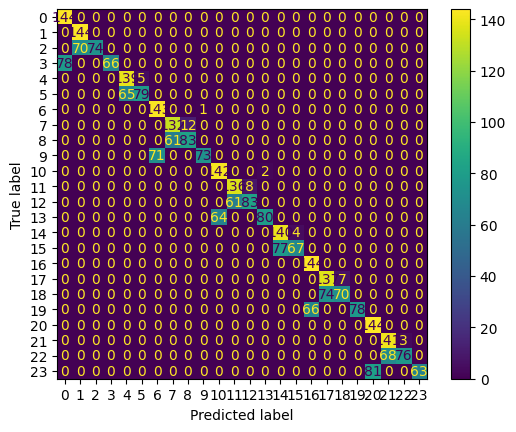

In [86]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_summary, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model = SVC(kernel="rbf")

cv = cross_val_score(model, X_summary, y, cv=5)

print(cv.mean())

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

y_pred_labels = le.inverse_transform(y_pred)
y_valid_labels = le.inverse_transform(y_valid)

acc = accuracy_score(y_pred, y_valid)

print(acc)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_valid_labels, y_pred_labels)
ConfusionMatrixDisplay(cm).plot()

y_pred.shape


import pandas as pd

df = pd.DataFrame({"Label": y_pred_labels, "Class": y_pred})

df[['Label', 'Class']].drop_duplicates().sort_values('Label')

# CNN

In [88]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Assuming X and y are loaded from your preprocessing

# Add channel dimension
X_cnn = X[..., np.newaxis]  # (samples, 12, max_frames, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_cnn, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_valid_cat = to_categorical(y_valid, num_classes)

# Define model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(12, X.shape[2], 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_valid, y_valid_cat),
    epochs=100,
    batch_size=32,
    verbose=2,
    callbacks=[early_stop]
)

y_pred_prob = model.predict(X_valid)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(cm).plot()


c:\Users\TheAiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\TheAiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
432/432 - 10s - 23ms/step - accuracy: 0.6415 - loss: 0.9160 - val_accuracy: 0.7193 - val_loss: 0.6900
Epoch 2/100
432/432 - 5s - 12ms/step - accuracy: 0.7231 - loss: 0.5585 - val_accuracy: 0.7335 - val_loss: 0.4993
Epoch 3/100
432/432 - 5s - 12ms/step - accuracy: 0.7310 - loss: 0.5197 - val_accuracy: 0.7500 - val_loss: 0.4644
Epoch 4/100
432/432 - 5s - 12ms/step - accuracy: 0.7384 - loss: 0.4968 - val_accuracy: 0.7271 - val_loss: 0.4855
Epoch 5/100
432/432 - 5s - 12ms/step - accuracy: 0.7428 - loss: 0.4853 - val_accuracy: 0.7483 - val_loss: 0.4724
Epoch 6/100
432/432 - 5s - 12ms/step - accuracy: 0.7522 - loss: 0.4649 - val_accuracy: 0.7474 - val_loss: 0.4389
Epoch 7/100
432/432 - 5s - 12ms/step - accuracy: 0.7503 - loss: 0.4613 - val_accuracy: 0.7584 - val_loss: 0.4220
Epoch 8/100
432/432 - 5s - 12ms/step - accuracy: 0.7557 - loss: 0.4453 - val_accuracy: 0.7523 - val_loss: 0.4304
Epoch 9/100
432/432 - 5s - 12ms/step - accuracy: 0.7594 - loss: 0.4364 - val_accuracy: 0.7465 -

KeyboardInterrupt: 

# Multi Headed CNN (paralell computing)

In [48]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import tensorflow as tf

def parse_chord(label):
    # Root is the first 1-2 chars (C, C#, D, D#, etc.)
    if len(label) > 1 and label[1] == '#':
        root = label[:2]
        quality = 'minor' if 'm' in label[2:] else 'major'
    else:
        root = label[0]
        quality = 'minor' if 'm' in label[1:] else 'major'
    return root, quality

roots, qualities = zip(*[parse_chord(lbl) for lbl in y])
roots = np.array(roots)
qualities = np.array(qualities)


# X shape: (samples, 12, max_frames)
X_cnn = X[..., np.newaxis]

# Suppose y contains full chord labels like 'C_major', 'D_minor', etc.
# We'll split them into quality and root
quality = np.array(['major' if 'major' in label else 'minor' for label in y])
root    = np.array([label.split('_')[0] for label in y])

le_root = LabelEncoder()
y_root_enc = le_root.fit_transform(roots)
y_root_cat = to_categorical(y_root_enc, num_classes=len(le_root.classes_))

le_quality = LabelEncoder()
y_quality_enc = le_quality.fit_transform(qualities)
y_quality_cat = to_categorical(y_quality_enc, num_classes=2)
# Train-validation split
X_train, X_valid, yq_train, yq_valid, yr_train, yr_valid = train_test_split(
    X_cnn, y_quality_cat, y_root_cat, test_size=0.2, random_state=42, stratify=y_quality_enc
)

# Input
inputs = Input(shape=(12, X.shape[2], 1))

# Shared CNN Encoder
x = Conv2D(32, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)

# Multi-task heads
quality_out = Dense(2, activation='softmax', name='quality')(x)
root_out    = Dense(12, activation='softmax', name='root')(x)

model = Model(inputs=inputs, outputs=[quality_out, root_out])

def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        loss = alpha * tf.pow(1. - pt, gamma) * cross_entropy
        return loss
    return loss_fn

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'quality':focal_loss(gamma=2.0, alpha=0.25), 'root':'categorical_crossentropy'},
    loss_weights={'quality':1.0, 'root':0.5},  # prioritize quality
    metrics={'quality':'accuracy','root':'accuracy'}
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train, {'quality': yq_train, 'root': yr_train},
    validation_data=(X_valid, {'quality': yq_valid, 'root': yr_valid}),
    epochs=100,
    batch_size=32,
    verbose=2,
    callbacks=[early_stop]
)

# Evaluate
yq_pred_prob, yr_pred_prob = model.predict(X_valid)
yq_pred = np.argmax(yq_pred_prob, axis=1)
yr_pred = np.argmax(yr_pred_prob, axis=1)

q_acc = accuracy_score(np.argmax(yq_valid, axis=1), yq_pred)
r_acc = accuracy_score(np.argmax(yr_valid, axis=1), yr_pred)

print(f"Validation Quality Accuracy: {q_acc:.4f}")
print(f"Validation Root Accuracy: {r_acc:.4f}")


Epoch 1/100


c:\Users\TheAiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


44/44 - 4s - 94ms/step - loss: 0.6914 - quality_accuracy: 0.5007 - quality_loss: 0.0982 - root_accuracy: 0.6700 - root_loss: 1.1804 - val_loss: 1.2334 - val_quality_accuracy: 0.5000 - val_quality_loss: 0.0441 - val_root_accuracy: 0.0867 - val_root_loss: 2.3780
Epoch 2/100
44/44 - 1s - 15ms/step - loss: 0.2054 - quality_accuracy: 0.5203 - quality_loss: 0.0717 - root_accuracy: 0.9530 - root_loss: 0.2813 - val_loss: 1.1522 - val_quality_accuracy: 0.5058 - val_quality_loss: 0.0435 - val_root_accuracy: 0.0896 - val_root_loss: 2.2152
Epoch 3/100
44/44 - 1s - 14ms/step - loss: 0.1367 - quality_accuracy: 0.5492 - quality_loss: 0.0625 - root_accuracy: 0.9761 - root_loss: 0.1536 - val_loss: 1.1072 - val_quality_accuracy: 0.4884 - val_quality_loss: 0.0437 - val_root_accuracy: 0.0723 - val_root_loss: 2.1247
Epoch 4/100
44/44 - 1s - 16ms/step - loss: 0.1089 - quality_accuracy: 0.5608 - quality_loss: 0.0578 - root_accuracy: 0.9841 - root_loss: 0.1063 - val_loss: 1.0417 - val_quality_accuracy: 0.4595

In [43]:
import numpy as np
import tensorflow as tf
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0  # placeholder for PANNs CNN14

# Assuming you have:
# - X_mel: list or np.array of mel spectrograms (samples, mel_bins=40, time_frames=max_frames)
# - y: list or np.array of labels (strings or ints)

# Resize mel bins from 40 → 64 to match pretrained model input
def resize_mel(mel, target_bins=64):
    # mel shape: (mel_bins, time_frames)
    # cv2.resize expects (width, height) so order: (time_frames, target_bins)
    mel_resized = cv2.resize(mel, (mel.shape[1], target_bins))  # width=time_frames, height=target_bins
    return mel_resized

mel_resized = np.array([resize_mel(mel) for mel in X_mel])  # shape: (samples, 64, max_frames)
print("Resized mel shape:", mel_resized.shape)  # e.g. (num_samples, 64, max_frames)

# Add channel dimension for Conv2D
X_cnn = mel_resized[..., np.newaxis]  # (samples, 64, max_frames, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# Split after resizing and channel add
X_train, X_valid, y_train, y_valid = train_test_split(
    X_cnn, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

y_train_cat = to_categorical(y_train, num_classes)
y_valid_cat = to_categorical(y_valid, num_classes)

# Model input shape must match X_cnn shape (excluding batch)
input_layer = Input(shape=(64, mel_resized.shape[2], 1))  # (64, max_frames, 1)

# Convert 1 channel to 3 channels for EfficientNet pretrained on ImageNet
x = tf.keras.layers.Conv2D(3, (3,3), padding='same')(input_layer)

backbone = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(64, mel_resized.shape[2], 3)
)(x)

x = GlobalAveragePooling2D()(backbone)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_valid, y_valid_cat),
    epochs=50,
    batch_size=32,
    verbose=2
)

# Evaluate
y_pred_prob = model.predict(X_valid)
y_pred = np.argmax(y_pred_prob, axis=1)
acc = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {acc:.4f}")


Resized mel shape: (1728, 64, 40)
Epoch 1/50
44/44 - 47s - 1s/step - accuracy: 0.1281 - loss: 3.0423 - val_accuracy: 0.0405 - val_loss: 3.2233
Epoch 2/50
44/44 - 9s - 205ms/step - accuracy: 0.3980 - loss: 2.0954 - val_accuracy: 0.0405 - val_loss: 3.2724
Epoch 3/50
44/44 - 9s - 199ms/step - accuracy: 0.5572 - loss: 1.5064 - val_accuracy: 0.0405 - val_loss: 3.2888
Epoch 4/50
44/44 - 9s - 198ms/step - accuracy: 0.6223 - loss: 1.1476 - val_accuracy: 0.0434 - val_loss: 3.2659
Epoch 5/50
44/44 - 9s - 208ms/step - accuracy: 0.6621 - loss: 0.9297 - val_accuracy: 0.0636 - val_loss: 3.2914
Epoch 6/50
44/44 - 9s - 208ms/step - accuracy: 0.7098 - loss: 0.7876 - val_accuracy: 0.0549 - val_loss: 3.2874
Epoch 7/50


KeyboardInterrupt: 